# Exploratory Data Analysis (EDA)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
%config InlineBackend.figure_format = 'retina'

In [2]:
clean_df = pd.read_csv('../data/clean.csv', index_col='Unnamed: 0')

In [3]:
clean_df.head()

,author,Anxiety,title,selftext,created_utc,retrieved_on,url,pinned,media_only,ADHD
0,5uperstud83,1.0,I’m curious if anyone has ever had severe musc...,I’ve been in horrible health the last several...,1593140513,1593140518,https://www.reddit.com/r/Anxiety/comments/hfzs...,False,False,0.0
1,Adept_Owl,1.0,Anyone else with vivid anxiety? (Possible trig...,By vivid I mean where scenarios run through yo...,1593139976,1593139977,https://www.reddit.com/r/Anxiety/comments/hfzo...,False,False,0.0
2,Ccerberus667,1.0,I have anxiety about certain technology like A...,The root of my that Ive had for a few years ...,1593139906,1593139909,https://www.reddit.com/r/Anxiety/comments/hfzn...,False,False,0.0
3,FinickyFlamingo1,1.0,My parents are signing me up for disability an...,"I want money, yes. But the fact that Im receiv...",1593139760,1593139766,https://www.reddit.com/r/Anxiety/comments/hfzm...,False,False,0.0
4,niajtima23,1.0,Compulsive exercise (running),when I first started exercising and began a re...,1593139752,1593139757,https://www.reddit.com/r/Anxiety/comments/hfzm...,False,False,0.0


Creating columns for word and character counts for the subreddit posts

In [4]:
clean_df['char_count'] = clean_df.selftext.map(len)

In [5]:
clean_df['word_count'] = clean_df.selftext.map(lambda x: len(x.split()))

In [13]:
clean_df.char_count.groupby(clean_df.ADHD).describe()

,count,mean,std,min,25%,50%,75%,max
ADHD,,,,,,,,
0.0,18616.0,849.094327,920.216415,1.0,312.0,601.0,1085.25,23178.0
1.0,17192.0,866.859935,990.508748,1.0,292.0,594.0,1111.00,26238.0


In [14]:
clean_df.word_count.groupby(clean_df.ADHD).describe()

,count,mean,std,min,25%,50%,75%,max
ADHD,,,,,,,,
0.0,18616.0,162.400193,175.159286,0.0,60.0,115.0,208.0,4531.0
1.0,17192.0,162.813169,183.803181,0.0,55.0,112.0,210.0,4654.0


As we can see, the average word and character counts for posts in the ADHD subreddit are very similar to the Anxiety subreddit, 162 and 866, respectively. However, averages can be misleading, since it does not give us any information about the skew of the data. As we can see with the gigantic standard deviations (due to the huge range in the minimum and maximum lengths), the mean does not tell the whole story. As such, below are some visualizations, to give us a better idea of how the lengths of posts are distributed.

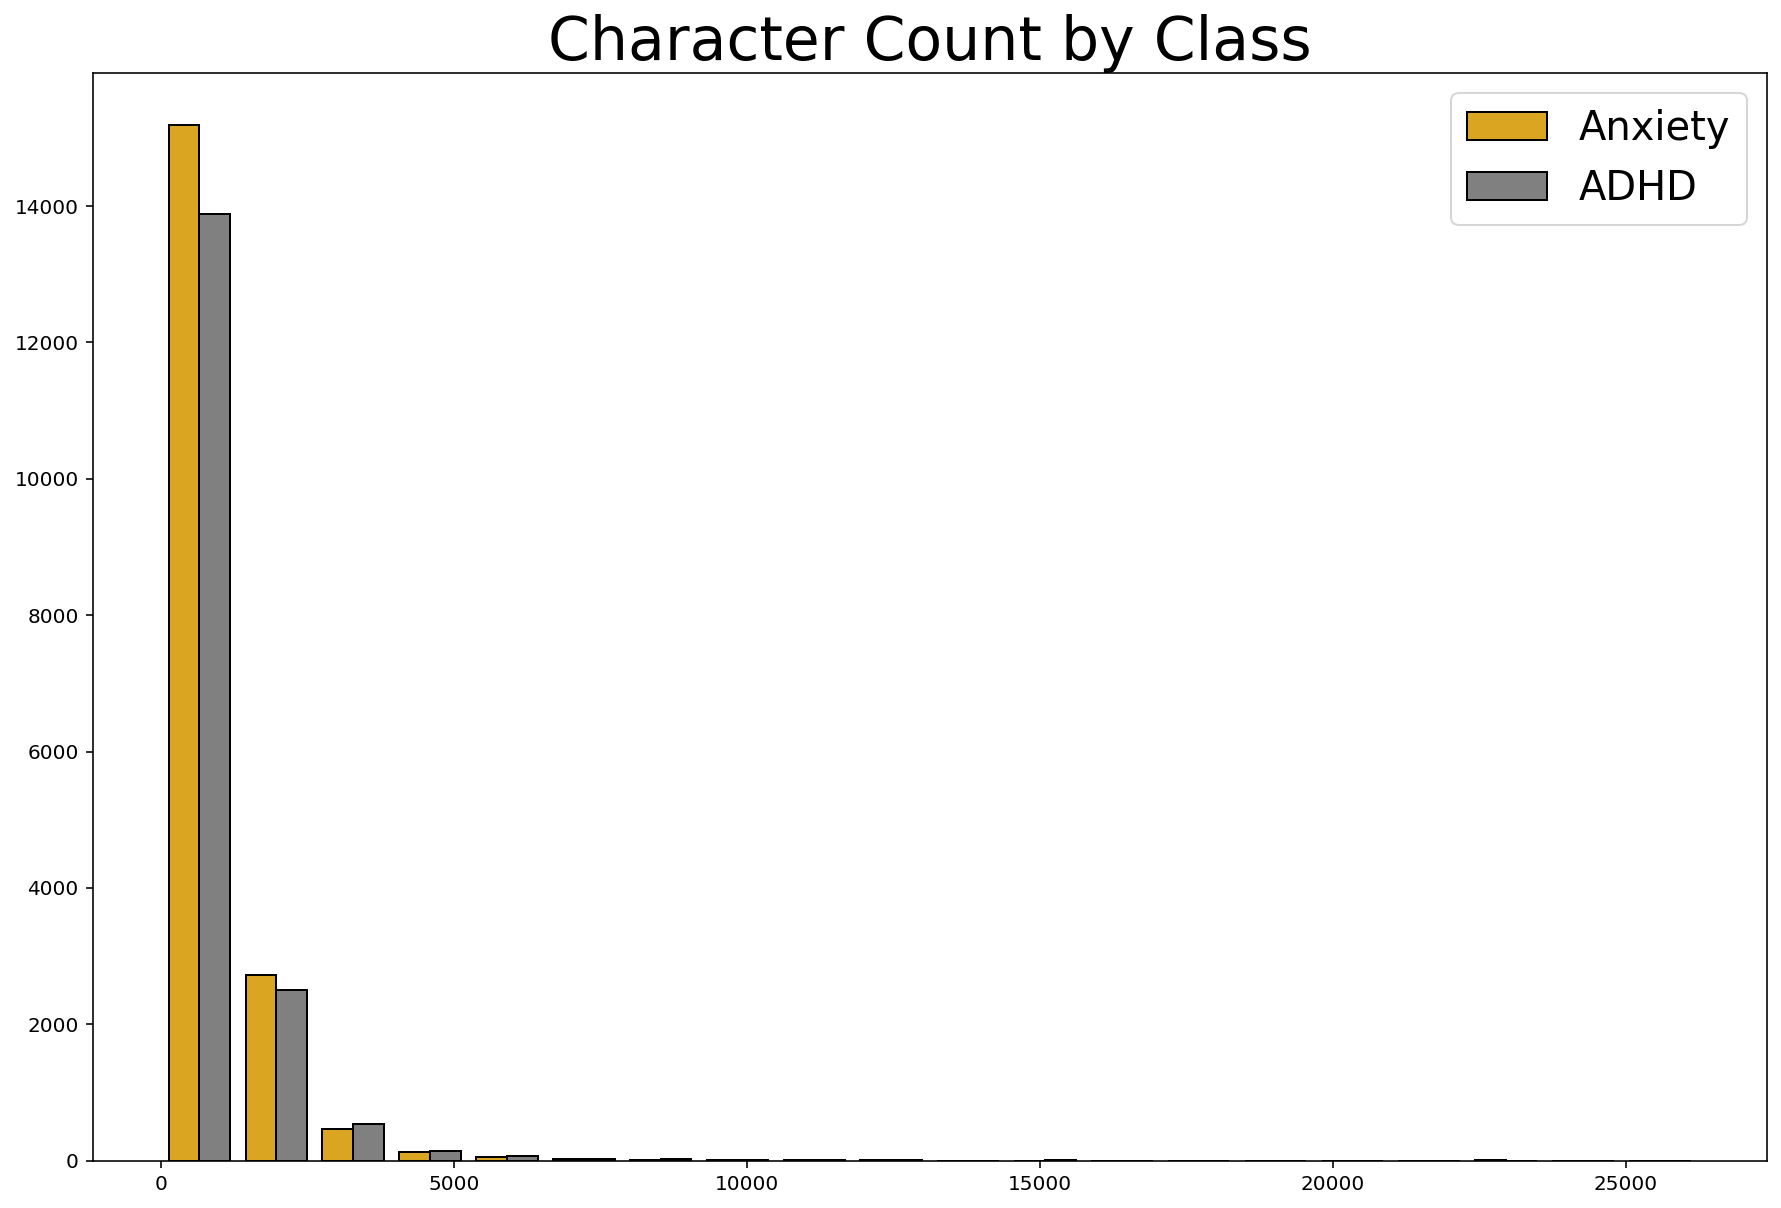

In [9]:
plt.figure(figsize=(15,10))
plt.hist([clean_df[clean_df['ADHD']==0]['char_count'], 
          clean_df[clean_df['ADHD']==1]['char_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Character Count by Class', fontsize=30)
plt.legend(['Anxiety', 'ADHD'], fontsize=20);

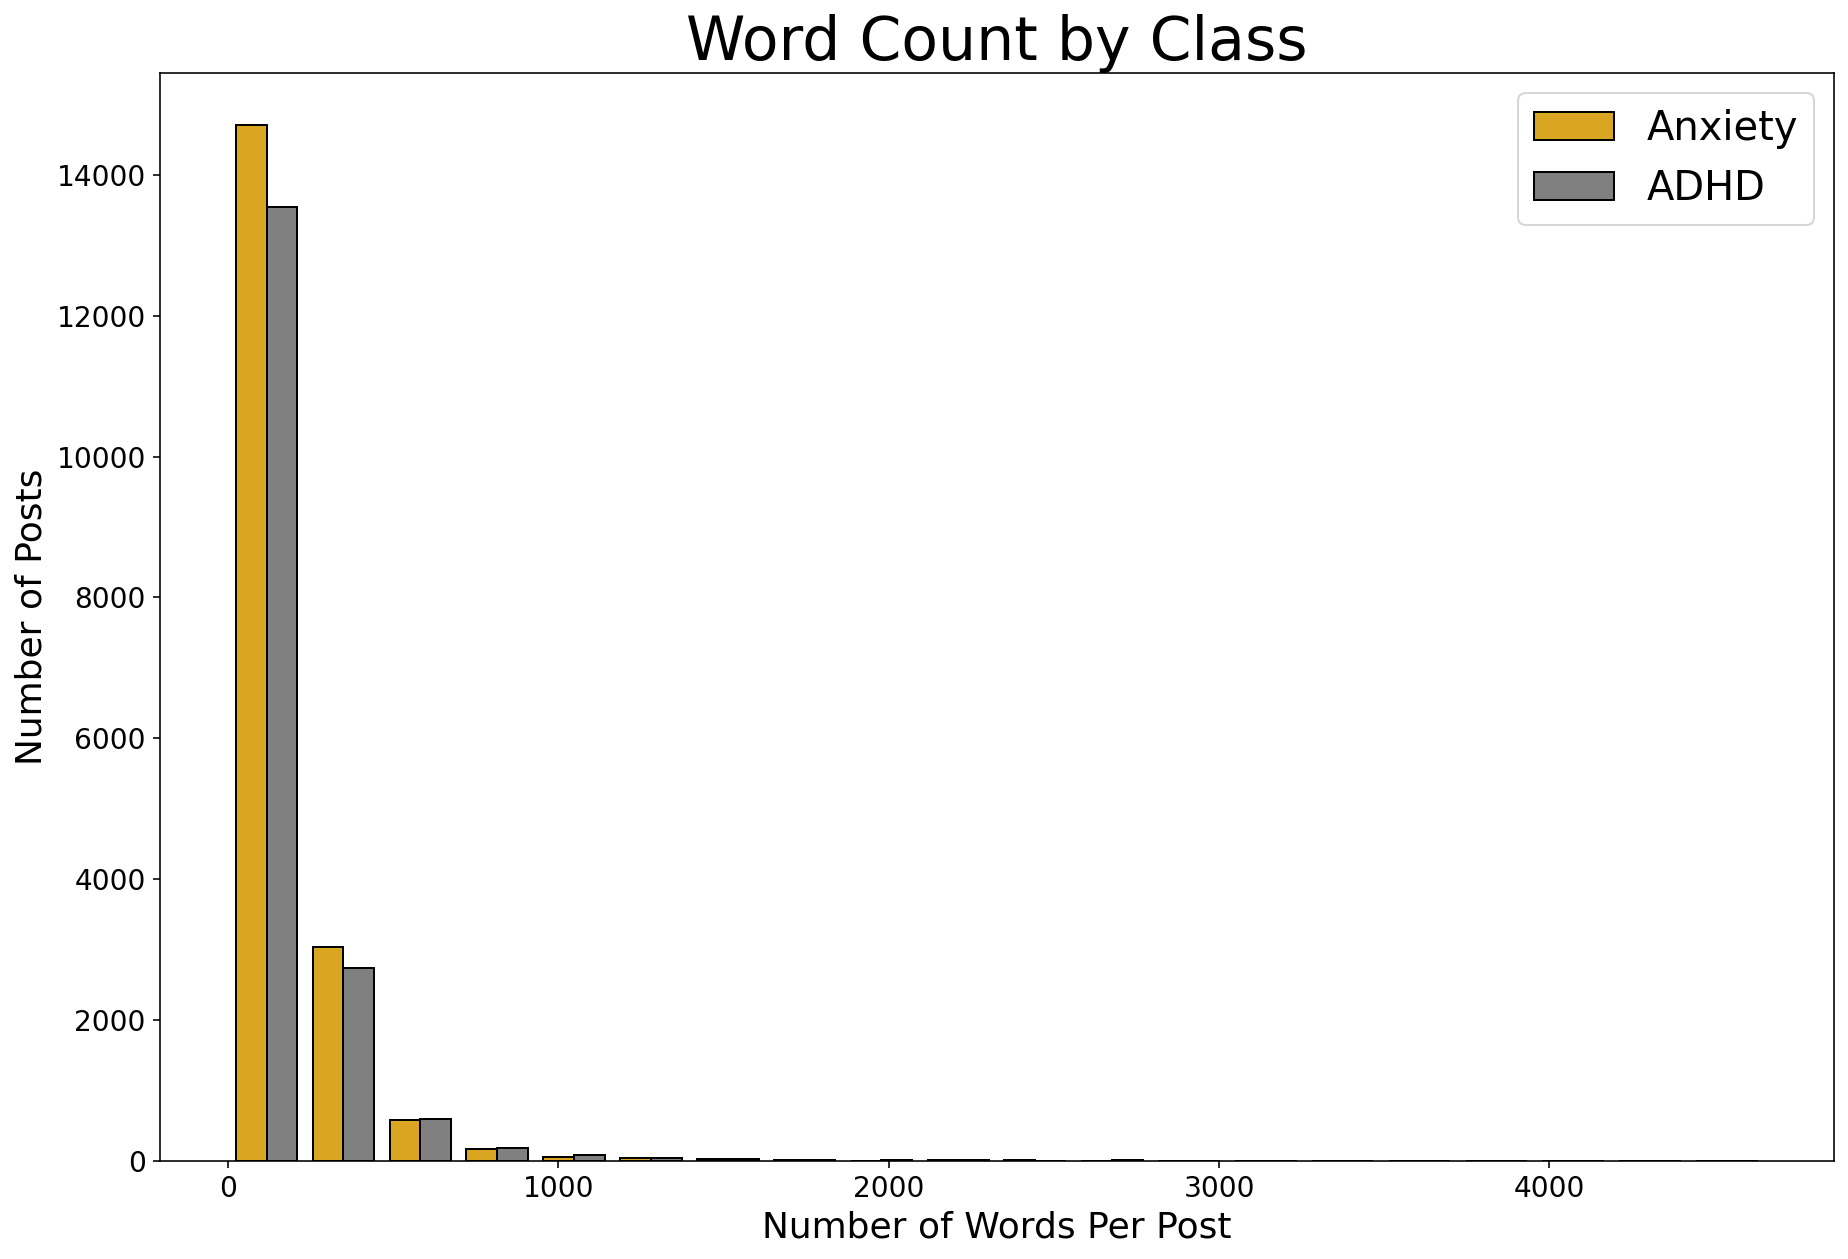

In [10]:
plt.figure(figsize=(15,10))
plt.hist([clean_df[clean_df['ADHD']==0]['word_count'], 
          clean_df[clean_df['ADHD']==1]['word_count']],
         bins=20, color=['goldenrod', 'grey'], ec='k')
plt.title('Word Count by Class', fontsize=30)
plt.legend(['Anxiety', 'ADHD'], fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of Words Per Post', fontsize=18)
plt.ylabel('Number of Posts', fontsize=18)
plt.savefig('../assets/wordcount.png');

As is expected, the vast majority of posts in both subreddits are very short, with very few posts having over 1000 words (hence the long right tails of the distributions).

---

# Natural Language Processing (NLP) Based EDA

Now we'll move on to more advanced NLP-based EDA. Before that, however, some preprocessing needs to be done, such as vectorizing our words and removing stop words. I add some custom stop_words that aren't included in the default Scikit-Learn library, because I encountered them later on in the process. Stop words are very common words that do not convey much meaning, which we explicitly tell our models to ignore.

In [15]:
custom_words = frozenset(['just', 'like', 'im', 'ive', 've', 'really', 'dont', 'don'])

In [16]:
stopwords = ENGLISH_STOP_WORDS.union(custom_words)

Using CountVectorizer for all posts, which takes all the words in the posts and creates columns of them containing the word's prevalence (i.e. frequency count). 

In [28]:
cvec = CountVectorizer(stop_words=stopwords, min_df=10, max_df=.9)

I set the minimum document frequency to be 10 (i.e. words must be in at least 10 posts to be included). This has the dual effect of removing any remaining typos, or mistakes, that my data cleaning notebook may have missed, and removing what I call the NLP version of outliers. 

As for setting the max_df to .9, that means that words that appear in more than 90% of all posts will be left out, because they are too common. My assumption here is that if a word is that common, in both subreddits, it cannot possibly be useful for meaningful insights.

In [31]:
word_matrix = cvec.fit_transform(clean_df['selftext'])

In [32]:
len(cvec.get_feature_names())

10157

After all the cleaning and excluding stop words, we are left with over 10000 words. I will now convert that word_matrix into a DataFrame for some EDA.

In [33]:
word_df = pd.DataFrame(term_matrix.toarray(), columns=cvec.get_feature_names())

Putting the ADHD column back into the dataframe.

In [34]:
word_df.insert(0, 'ADHD', clean_df.ADHD)

In [35]:
word_df.head()

,ADHD,00,000,00am,00pm,10,100,1000,100mg,100s,...,zen,zero,zinc,zoloft,zombie,zone,zoned,zones,zoning,zoom
0,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now looking at a snapshot of distributions for the words between the ADHD and Anxiety subreddits.

In [36]:
word_df.groupby('ADHD').mean()

,00,000,00am,00pm,10,100,1000,100mg,100s,100x,...,zen,zero,zinc,zoloft,zombie,zone,zoned,zones,zoning,zoom
ADHD,,,,,,,,,,,,,,,,,,,,,
0.0,0.003116,0.002202,0.000591,0.000376,0.050279,0.020789,0.001880,0.002686,0.000376,0.000483,...,0.000537,0.006339,0.000215,0.019714,0.00231,0.005748,0.000430,0.000376,0.000645,0.006983
1.0,0.004120,0.003458,0.001471,0.001177,0.069962,0.023836,0.003163,0.001545,0.000589,0.000368,...,0.000441,0.009784,0.000441,0.003973,0.00515,0.010594,0.003237,0.000441,0.004929,0.008019


In [37]:
word_df.groupby('ADHD').sum()

,00,000,00am,00pm,10,100,1000,100mg,100s,100x,...,zen,zero,zinc,zoloft,zombie,zone,zoned,zones,zoning,zoom
ADHD,,,,,,,,,,,,,,,,,,,,,
0.0,58,41,11,7,936,387,35,50,7,9,...,10,118,4,367,43,107,8,7,12,130
1.0,56,47,20,16,951,324,43,21,8,5,...,6,133,6,54,70,144,44,6,67,109


The above outputs are not easy on the eyes, but by transposing them and sorting by one of our groups, we can more easily see what are the most used words.

In [38]:
# sorted by ADHD, the right-hand column
word_df.groupby('ADHD').mean().T.sort_values(1, ascending=False).head(20)

ADHD,0.0,1.0
feel,0.906317,0.596925
time,0.527181,0.577724
know,0.652557,0.548518
things,0.328051,0.436107
work,0.288086,0.418377
people,0.391169,0.364379
want,0.415610,0.347090
day,0.333423,0.333775
life,0.306564,0.325020
think,0.343361,0.312220


In [40]:
# sorted by ADHD, the right-hand column
word_df.groupby('ADHD').sum().T.sort_values(1, ascending=False).head(20)

ADHD,0.0,1.0
feel,16872,8114
time,9814,7853
know,12148,7456
things,6107,5928
work,5363,5687
people,7282,4953
want,7737,4718
day,6207,4537
life,5707,4418
think,6392,4244


It's no surprise that the most frequently used words are 'feel' and 'time,' since time management is one of the biggest struggles for those with ADHD. It seems as though there may be quite a bit of overlap, but let's grab the top 20 terms in each subreddit and systematically look at the overlapping words.

In [41]:
top_words_anxiety = list(word_df.groupby('ADHD').mean().T.sort_values(0, ascending=False).head(20).index)

top_words_adhd = list(word_df.groupby('ADHD').mean().T.sort_values(1, ascending=False).head(20).index)

In [42]:
top_words_overlap = [word for word in top_words_adhd if word in top_words_anxiety]

In [43]:
top_words_overlap

['feel',
 'time',
 'know',
 'things',
 'work',
 'people',
 'want',
 'day',
 'life',
 'think',
 'help',
 'got',
 'going',
 'years']

We can see that 14 out of the top 20 words for each subreddit overlap with one another, which lends credence to my problem statement and the issues regarding misdiagnosis. In my next notebook, I'll be diving into predictive and inferential modeling, to see how well I can predict which subreddit the post came from, and which words were the strongest predictors.